# Simulación de Eventos Discretos - TP1

**Integrantes**: Tobías Carrerira Munich y Valentín Paz Marcolla


En este trabajo práctico buscamos modelar un sub-sistema del comercio internacional. Éste debe ser compatible con la definición de [Product Space](https://atlas.cid.harvard.edu/), tal que podamos observar Product Spaces subyancentes de las simulaciones que se hagan sobre éste.

Nos interesa particularmente la relación entre el características del Product Space y los indicadores socioeconómicos de los distintos países que forman parte de esta red. Entendemos que **los países quieren progresar y pueden usar (alguna) información del Product Space para tomar decisiones** respecto de políticas públicas, inversiones, oportunidades a corto y largo plazo con el objeto de mejorar en marcadores tales como PBI, PBI per cápita, GINI, formalidad laboral, etc. Existen (y fueron demostradas) correlaciones significativas entre estos indicadores y variables del Product Space como el Economic Complexity Index (ECI) o el Relative Competitive Advantage (RCA), por lo que se puede generar un paralelismo razonable entre “avanzar” en el Product Space y mejorar la economía y sociedad de un país.

Asignaremos **estrategias de crecimiento** a cada país y ajustaremos los parámetros de las mismas en función de datos reales de la economía de cada uno de ellos. Luego **a través de un Mercado internacional determinados Productos serán demandados a los países**, dado que los recursos productivos son finitos, determinados y dispares el Mercado deberá distribuir las demandas respetando esta disparidad, que también se puede observar en el Product Space.

En concreto, el problema que estamos tratando de resolver se basa en una situación real -el intercambio de bienes entre países y sus trayectorias socioeconómicas- pero que trataremos de forma idealizada. A partir de esta modelización, trataremos de responder las siguientes preguntas: ¿cómo se modifica la descripción en el Product Space de los países según sus distintas estrategias? Después de cierto tiempo, ¿se alcanzan valores estables y comunes para indicadores socioeconómicos como el índice de GINI? ¿Cómo evoluciona la desigualdad cuando la demanda de productos fluctúa altamente? ¿Cómo impacta en la desigualdad y en los productos exportados el hecho de que la priorización de nuevos productos se base únicamente en el RCA (Relative Competitive Advantage)? ¿Cómo se comparan las estrategias evaluadas con la selección aleatoria de nuevos productos? (Estrategia random de crecimiento - modelo nulo).

---
**NOTA**

Por restricciones temporales y de conocimiento no llegamos a incluir en el modelo y posterior analisis a todas estas preguntas. En particular, no logramos incluir indicadores de bienestar socioeconómico (por ejemplo, GINI).

Conseguimos implementar dos estrategias de crecimiento distintas: una más conservadora, que decide seguis exportando los productos conocidos por el pais, y una más arriesgada que busca diversificar. Esta última va a producir productos que le son más similares a su cartera de productos actual.


----


Modelo conceptual
=================

Tenemos tres tipos de componentes: el mercado, los productos y los paises. Cada año, se generarán pedidos de productos para los paises y estos decidirán si cumplen con estas demandas, también lo pueden hacer de forma parcial. En la simulación, un año equivale a una hora de tiempo virtual.


![Modelo conceptual](modelo-conceptual.png "Modelo conceptual")


La dinámica de los productos es la de crecimiento lineal ajustado por una regresión a [datos reales](https://atlas.cid.harvard.edu/data-downloads). Estos determinan la demanda que se realizará de cada producto para ese año.

El mercado recibe la demanda de cada producto y decide como dividirla entre los distintos paises. Para cada producto, el 80% de la demanda es dividida entre los paises que ya lo producían el año anterior respetando la proporción de cúanto producían (sostén de la producción), un 10% se divide entre cinco paises que no lo exportaban (de forma aleatoria), y el restante 10% se distribuye entre los países que producían los productos pero asignado de forma equitativa (aumento de la producción).

El mercado le ofrece demanda a los países de forma secuencial: si el primer país no cumple con una demanda para un producto, esta se distribuirá (equitativamente) entre todos los paises a los cuales se decidió demandarle para este año.

Cada país recibirá una tupla con las demandas que le corresponden de cada producto. Cada país cuenta con una medida de su PBI, que inicia con datos reales y crece en la misma proporción que sus exportaciones. Al recibir demandas, podrá utilizar alguna estrategia para asignar su presupuesto de reinversión (el cual determinamos como 1% del PBI) para aumentar su producción en algún producto o producir nuevos.

Diremos que el costo de producción por dolar no previamente exportado (incremento) de producto es: $costo_p = \frac{1}{2} \cdot 10^{(1 - proximidad_{p,c})}$ donde $p$ es el producto, $c$ el pais y $proximidad$ es la distancia entre $p$ y los productos producidos por el país $c$ el el Espacio de Productos, o 1 si $p$ ya es exportado por $c$.

Los países tienen implementada una estrategia conservadora, la cual usaremos en los próximos análisis. Esta estrategia divide el presupuesto entre los productos que ya fueron producidos por el pais durante el año anterior y cuya demanda aumentó, de forma equitativa con respecto al extra demandado.

El modelo fue pensado de forma extensible: pueden agregarse nuevas estrategias, indicadores socioeconómicos y otros comportamientos de forma simple y bien modularizada requiriendo cambios solamente en componentes particulares.

Descripción formal
------------------

#### País
- **Estado**: Está determinado por una tupla de P lugares (con P = cantidad de productos del modelo) que almacena el volúmen exportado de cada producto por ese país el año anterior.
- **Parámetros**:
    - PBI / exportaciones
    - Estrategia: 1 para conservadora y 2 para exploradora
- **Puertos de entrada**:
    - ``demand``: se recibe una tupla con los pedidos del Mercado al país donde cada posición de ella representa el volúmen en U$D demandado de un producto.
- **Puertos de salida**:
    - ``supply``: se emite una tupla como la mencionada, donde las posiciones representan el volúmen efectivo exportado en U$D de los productos por este país.

#### Producto
- **Estado**: Determinado por el volúmen en U$D efectivamente exportado de ese producto en el año anterior.
- **Parámetros**:
    - Volúmen en U$D inicial (exportación mundial en 1995)
    - Velocidad de crecimiento (utilizado como pendiente de la función lineal que rige el volúmen demandado para el producto)
- **Puertos de salida**:
    - ``demand``: cada año el producto emite por este canal la demanda en volúmen en U$D (número).
- **Puertos de entrada**:
    - ``supply``: medio por el cual el producto se informa de la producción mundial efectiva para ese año (conectado con el Mercado).

#### Mercado
- **Estado**: Combinación entre volúmen pedido de todos los productos (demandas) y volúmen pedido y exportado de cada producto para cada país (demandado a países y oferta). Además, cuenta con un ordenamiento que se renueva todos los años, utilizado para demandar a los países.
- **Parámetros**:
    - Cantidad de productos
    - Cantidad de países
- **Puertos de entrada**:
    - ``demand_pi``: recibe del producto i-ésimo el volúmen demandado en U$D para ese año (conectado con ``demand`` del producto).
    - ``supply_ci``: recibe una tupla con los volúmenes exportados efectivamente por el país i-ésimo este año (conectado con ``suppply`` del país).
- **Puertos de salida**:
    - ``demand_ci``: luego de recibir las demandas de los productos, emite una tupla con los volúmenes asignados por la lógica del mercado al país i-ésimo (conectado con ``demand`` del país).
    - ``supply_pi``: una vez terminado el proceso de pedidos y respuestas a los países por este puerto se informa el volúmen efectivo exportado ese año al producto i-ésimo (conectado con ``supply`` del producto).

# Simulación Modelo Estrategia Conservadora

Como primer paso, corremos un script que genera el archivo .ma con los datos reales de paises y productos.
Luego corremos el modelo durante 20 años, ejecutar la siguiente celda produce siempre los mismos resultados.

In [56]:
%%bash

cd model

python3 generate_ma.py

mkdir -p logs
src/bin/cd++ -m model/simulationConservative.ma \
             -t 20:00:00:000 \
             -l logs/simulation.log \
             -o simulation.out

A continuación mostramos los resultados, sin embargo para ejecutarlo a mano ver sección ``Ejecutar exprimentación``.

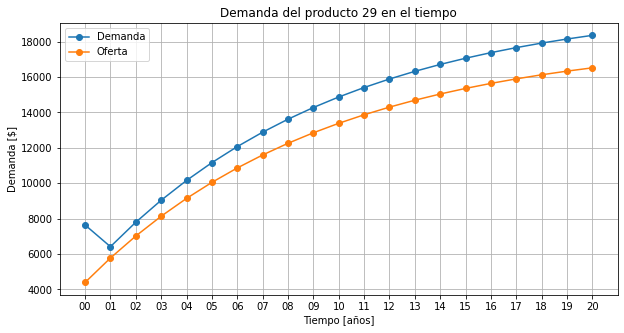

In [ ]:
plot_product_demand(29)

Argentina:

In [ ]:
df = supply_country(11)
fig = px.line(df, x="time", y="value", color="product", title="Exportaciones en Millones de U$D por producto para ARG")
fig.show()

df = gdp(11)
fig = px.line(df, x="time", y="value", title="PBI en Millones de U$D para ARG")
fig.show()

Vemos que para Argentina el producto 29 crece ampliamente, condicionando el desarrollo de otros, si bien muchos están en lento aumento.

También observamos que hay varios productos que bajan su demanda al país, durante los primeros años muy fuertemente y luego "sostienen" su demanda (tangencialmente decreciente). Éstos son 58 y 71 princialmente, veamos cuál es su demanda y oferta mundial total.

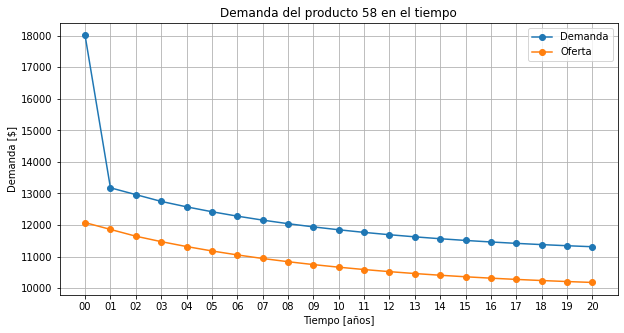

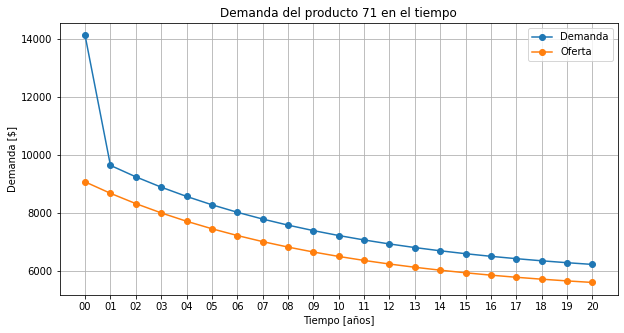

In [ ]:
plot_product_demand(58)
plot_product_demand(71)

Claramente, se reduce la demanda de los productos año a año, por lo que Argentina no es un caso aislado, veamos el de Bélgica, con un comportamiento similar para estos productos.

In [ ]:
df = supply_country(62)
df = df[(df["product"] == 58) | (df["product"] == 71)]
fig = px.line(df, x="time", y="value", color="product", title="Exportaciones de p58 y p71 en Millones de U$D para BEL")
fig.show()

Uruguay:

In [ ]:
df = supply_country(17)
fig = px.line(df, x="time", y="value", color="product", title="Exportaciones en Millones de U$D por producto para URY")
fig.show()

df = gdp(17)
fig = px.line(df, x="time", y="value", title="PBI en Millones de U$D para URY")
fig.show()

En el caso de Uruguay, vemos que muchos de sus productos crecen, pero luego se "estancan", en términos macroeconómcos el PBI sigue aumentando, pero no se debe a una explosión de algún producto en particular, como si lo es el caso de Argentina (y también de México).

Mexico

In [ ]:
df = supply_country(48)
fig = px.line(df, x="time", y="value", color="product", title="Exportaciones en U$D por producto para MEX")
fig.show()

df = gdp(48)
fig = px.line(df, x="time", y="value", title="PBI en U$D  para MEX")
fig.show()

Observamos que el producto 29 crece mucho para paises que ya lo exportan, como Mexico y Argentina, sin embargo esta dinamica no afecta, por ejemplo, a Urguay. Vemos que este crecimiento acelerado y sostenido se da porque el producto 29 crece mucho. Más que duplicarse en 20 años.

También vemos que el mundo puede adaptarse a la demanda de éste producto, siguiendo la tendencia, pero cada vez se bifurca más, es decir, suponemos que se alcanza una capacidad productiva máxima. Sin introducir al modelo grandes modificaciones que permitan generar saltos cuantitativos de producción (grandes inversiones/mejoras en los procesos de producción), nunca se va a conseguir satisfacer la demanda.

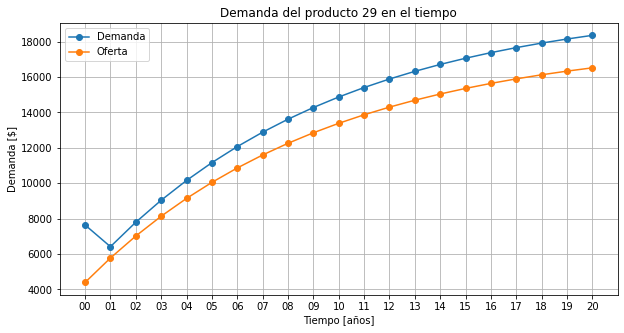

In [ ]:
plot_product_demand(29)

Conclusiones sobre la verificación del modelo:

Se puede adjudicar el comportamiento de los países sobre los distintos productos a la demanda que reciben por parte del mercado, esto es positivo ya que no se arriesgan ni hacen saltos de producción. Esto se condice con lo que modelamos. Es evidente que no poner determinantes sobre lo que ya exportaba un país fomenta que se crezcan aquellos productos que ya se hacían y no explora sectores nuevos. Esto hace que los países limiten su crecimiento según el mercado global, no solamente de la política de desarrollo elegida (si bien esto no hubiera gustado constrastarlo con otras estrategias de crecimiento, no sólo conservador).

No tener variaciones sobre la curva de demandas de productos (monotonía) trae consigo la limitación de que el grueso de la producción no cambia de países, ya que la monotonía se "transfiere" de la curva mundial a la individual de cada país productor, dejando muy poco volúmen (aprox. < 2% de la demanda) para países nuevos.

Con el estado del Trabajo Práctico no podemos responder (ni acercarnos a hipotetizar) sobre las preguntas originales. Fuera de la limitación inherente a la complejidad de este modelo y los comportamientos de los componentes, también graficar el Espacio de Productos y observar propiedades sobre éste resultó un desafio un poco excesivo para un Trabajo Práctico.

## Ejecutar experimentación

Cargamos los datos de salida de la simulación:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# definimos los path a los archivos de interés
OUT_FILENAME = "simulation.out"

# definimos los nombres de las columnas en los dataframes de pandas
TIME_COL = 'time'
PORT_COL = 'port'
VALUE_COL = 'value'
# MESSAGE_TYPE_COL = 'message_type'
# MODEL_ORIGIN_COL = 'model_origin'
# MODEL_DEST_COL = 'model_dest'

# parsea cada fila del dataframe
def parse_value(value: str):
    if '?' in value: return None
    is_list = value.strip().startswith("[") and value.strip().endswith("]")
    if is_list:
        return tuple(float(num) for num in value.replace('[', '').replace(']', '').split(', '))
    return float(value)

# conversion VTime a float
def time_to_years(time):
    h, m, s, ms, r = time.split(':')
    return h

df_converters = {
    VALUE_COL: parse_value,
    TIME_COL: time_to_years
}

salida = pd.read_csv(OUT_FILENAME,
                     delimiter=r'(?<!,)\s+',
                     engine='python',  # C engine doesnt work for regex
                     converters=df_converters,
                     names=[TIME_COL, PORT_COL, VALUE_COL]
                    )

# veamos cómo luce el dataframe con los datos de salida
salida[[f'demand_c{0}' == port for port in salida[PORT_COL]]][VALUE_COL].head() # filtro por índice

240     (59.124, 16.9914, 4.36462, 474.454, 2.78084, 6...
489     (0.0, 2.61165, 0.811153, 69.1693, 0.473376, 9....
858     (0.0, 3.08306, 1.06135, 78.188, 0.509154, 11.4...
1188    (0.0, 3.5317, 1.3071, 86.1925, 0.531097, 13.41...
1530    (0.0, 3.94126, 1.5466, 93.4218, 0.540359, 15.2...
Name: value, dtype: object

In [2]:
countries_iso = {}
with open("model/simulationConservative.ma") as f:
    i = None
    iso = None
    for l in f.readlines():
        if "[c" in l:
            i = int(l[2:-2])
        elif "iso3Code : " in l:
            iso = l[-4:-1]

        if i is not None and iso:
            countries_iso[i] = iso
            i = iso = None

In [3]:
# TODO: cambiar para que use los nuevos nombres de puertos
def demand_product(product):
    return salida[salida[PORT_COL] == f'demand_p{product}']

def supply_product(product):
    return salida[salida[PORT_COL] == f'supply_p{product}']

def demand_country(country):
    return salida[salida[PORT_COL] == f'demand_c{country}']

def supply_country(country):
    return pd.DataFrame(data=[(x.time, x.port, p,  y) for _, x in salida[salida[PORT_COL] == f'supply_c{country}'].iterrows() for p, y in enumerate(x.value)], columns=["time", "port", "product", "value"])

def gdp(country):
    return salida[salida[PORT_COL] == f'gdp_c{country}']

In [4]:
import plotly.express as px

In [5]:
def plot_product_demand(product):
    plt.figure(figsize=(10,5))
    plt.plot(TIME_COL, VALUE_COL, data=demand_product(product), marker='o', label='Demanda')
    plt.plot(TIME_COL, VALUE_COL, data=supply_product(product), marker='o', label='Oferta')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Tiempo [años]')
    plt.ylabel('Demanda [$]')
    plt.title(f'Demanda del producto {product} en el tiempo')

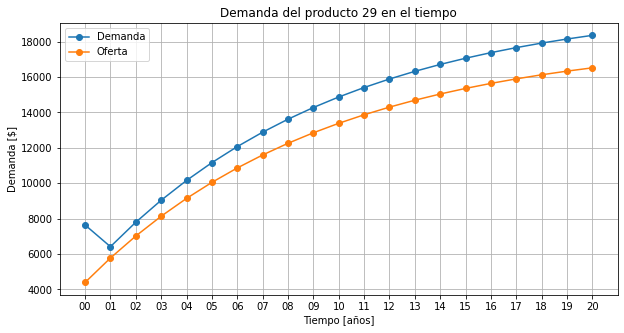

In [6]:
plot_product_demand(29)

In [7]:
def plot_country_export(country):
    df = supply_country(country)
    xs = df[TIME_COL]

    plt.figure(figsize=(10,5))
    product_exports = [[] for _ in df[VALUE_COL].iloc[0]]
    for t in df[VALUE_COL]:
        for i, val in enumerate(t):
            product_exports[i].append(val)
    for i, exports in enumerate(product_exports):
        plt.plot(xs, exports, marker='o')
    plt.grid(True)
    # plt.legend()
    plt.xlabel('Tiempo [años]')
    plt.ylabel('Exportaciones [$]')
    plt.title(f'Exportación del pais {countries_iso[country]}')

Argentina:

In [8]:
df = supply_country(11)
fig = px.line(df, x="time", y="value", color="product", title="Exportaciones en Millones de U$D por producto para ARG")
fig.show()

df = gdp(11)
fig = px.line(df, x="time", y="value", title="PBI en Millones de U$D para ARG")
fig.show()

Vemos que para Argentina el producto 29 crece ampliamente, condicionando el desarrollo de otros, si bien muchos están en lento aumento.

También observamos que hay varios productos que bajan su demanda al país, durante los primeros años muy fuertemente y luego "sostienen" su demanda (tangencialmente decreciente). Éstos son 58 y 71 princialmente, veamos cuál es su demanda y oferta mundial total.

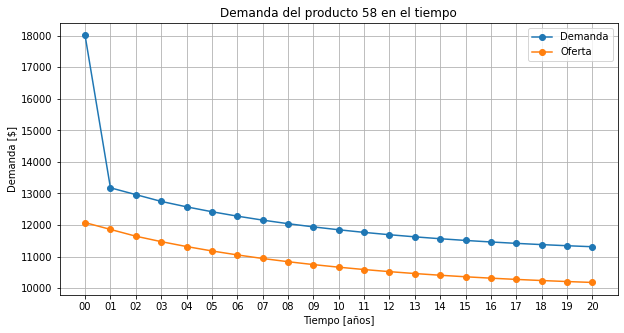

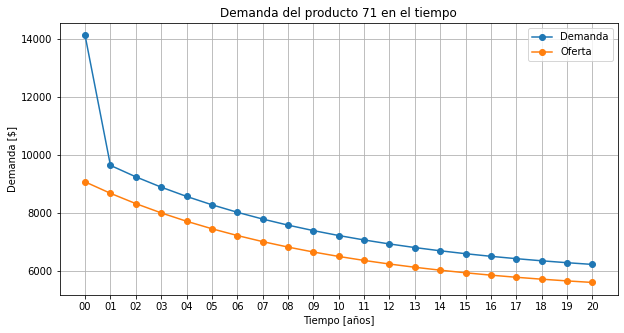

In [9]:
plot_product_demand(58)
plot_product_demand(71)

Claramente, se reduce la demanda de los productos año a año, por lo que Argentina no es un caso aislado, veamos el de Bélgica, con un comportamiento similar para estos productos.

In [10]:
df = supply_country(62)
df = df[(df["product"] == 58) | (df["product"] == 71)]
fig = px.line(df, x="time", y="value", color="product", title="Exportaciones de p58 y p71 en Millones de U$D para BEL")
fig.show()

Uruguay:

In [11]:
df = supply_country(17)
fig = px.line(df, x="time", y="value", color="product", title="Exportaciones en Millones de U$D por producto para URY")
fig.show()

df = gdp(17)
fig = px.line(df, x="time", y="value", title="PBI en Millones de U$D para URY")
fig.show()

En el caso de Uruguay, vemos que muchos de sus productos crecen, pero luego se "estancan", en términos macroeconómcos el PBI sigue aumentando, pero no se debe a una explosión de algún producto en particular, como si lo es el caso de Argentina (y también de México).

Mexico

In [12]:
df = supply_country(48)
fig = px.line(df, x="time", y="value", color="product", title="Exportaciones en U$D por producto para MEX")
fig.show()

df = gdp(48)
fig = px.line(df, x="time", y="value", title="PBI en U$D  para MEX")
fig.show()

Observamos que **el producto 29 crece mucho para paises que ya lo exportan, como Mexico y Argentina,** sin embargo esta dinamica no afecta, por ejemplo, a Urguay. Vemos que este crecimiento acelerado y sostenido se da porque el producto 29 crece mucho. Más que duplicarse en 20 años.

También vemos que el mundo puede adaptarse a la demanda de éste producto, siguiendo la tendencia, pero cada vez se bifurca más, es decir, suponemos que se alcanza una capacidad productiva máxima. Sin introducir al modelo grandes modificaciones que permitan generar saltos cuantitativos de producción (grandes inversiones/mejoras en los procesos de producción), nunca se va a conseguir satisfacer la demanda.

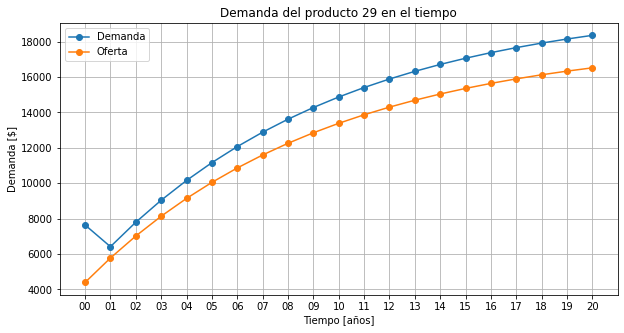

In [13]:
plot_product_demand(29)

## Conclusiones sobre la verificación del modelo:

Se puede adjudicar el **comportamiento de los países sobre los distintos productos a la demanda que reciben por parte del mercado**, esto es positivo ya que no se arriesgan ni hacen saltos de producción. **Esto se condice con lo que modelamos**. Es evidente que no poner determinantes sobre lo que ya exportaba un país fomenta que se crezcan aquellos productos que ya se hacían y no explora sectores nuevos. Esto hace que los **países limiten su crecimiento según el mercado global**, no solamente de la política de desarrollo elegida (si bien esto no hubiera gustado constrastarlo con otras estrategias de crecimiento, no sólo conservador).

No tener variaciones sobre la curva de demandas de productos (monotonía) trae consigo la limitación de que **el grueso de la producción no cambia de países**, ya que la monotonía se "transfiere" de la curva mundial a la individual de cada país productor, dejando muy poco volúmen (aprox. < 2% de la demanda) para países nuevos.

Con el estado del Trabajo Práctico no podemos responder (ni acercarnos a hipotetizar) sobre las preguntas originales. Fuera de la limitación inherente a la complejidad de este modelo y los comportamientos de los componentes, también graficar el Espacio de Productos y observar propiedades sobre éste resultó un desafio un poco excesivo para un Trabajo Práctico.